# 코로나 관련 상품 판매 데이터 분석

## 1. 데이터 로드

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import sys

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno


data = pd.read_csv('/content/drive/MyDrive/ML_Practice/04_covid_amz_ml/amz_data.csv')
data.head()

,index,product,name,mrp_now,price_now,star1,star2,star3,star4,star5,mrp_then,price_then
0,0,facemasks,SURGICOMFORT Non Woven Elastic Ear-Loop Dispos...,1000.0,151.0,24.0,9.0,13.0,14.0,24.0,NaN,NaN
1,1,facemasks,Mediweave Reusable 100% Cotton Cloth Face Mask...,499.0,324.0,27.0,12.0,15.0,17.0,27.0,NaN,NaN
2,2,facemasks,RSM 3 Layer Non-Woven Disposable Medical Face ...,349.0,249.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,3,facemasks,Steelbird SBA-2 7Wings Unisex Helmet Visor Fac...,898.0,799.0,61.0,3.0,6.0,25.0,61.0,NaN,NaN
4,4,facemasks,Vocado 5 Layer Filter Protection Face Mask Kn9...,399.0,121.0,19.0,11.0,14.0,16.0,19.0,NaN,NaN


#### 데이터 설명
- mrp_now : 인도나 방글라데시에서 팔 수 있는 해당 제품의 최고 가격
- mrp_then : 이전 mrp(이전 해당 제품의 최고 가격)
- price_then : 이전 mrp 시점 가격(mrp_then일 때 상품 가격)
- star : 평점 개수


In [ ]:
# index 컬럼 삭제
data.drop(['index'],axis=1, inplace=True)
data.head()

,product,name,mrp_now,price_now,star1,star2,star3,star4,star5,mrp_then,price_then
0,facemasks,SURGICOMFORT Non Woven Elastic Ear-Loop Dispos...,1000.0,151.0,24.0,9.0,13.0,14.0,24.0,NaN,NaN
1,facemasks,Mediweave Reusable 100% Cotton Cloth Face Mask...,499.0,324.0,27.0,12.0,15.0,17.0,27.0,NaN,NaN
2,facemasks,RSM 3 Layer Non-Woven Disposable Medical Face ...,349.0,249.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,facemasks,Steelbird SBA-2 7Wings Unisex Helmet Visor Fac...,898.0,799.0,61.0,3.0,6.0,25.0,61.0,NaN,NaN
4,facemasks,Vocado 5 Layer Filter Protection Face Mask Kn9...,399.0,121.0,19.0,11.0,14.0,16.0,19.0,NaN,NaN


## 2. 데이터 EDA

In [ ]:
# 데이터 형태 확인
data.shape

(737, 11)

In [ ]:
# 데이터 타입 확인 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 737 entries, 0 to 736
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   product     737 non-null    object 
 1   name        737 non-null    object 
 2   mrp_now     277 non-null    float64
 3   price_now   277 non-null    float64
 4   star1       277 non-null    float64
 5   star2       277 non-null    float64
 6   star3       277 non-null    float64
 7   star4       277 non-null    float64
 8   star5       277 non-null    float64
 9   mrp_then    354 non-null    float64
 10  price_then  354 non-null    float64
dtypes: float64(9), object(2)
memory usage: 63.5+ KB


In [ ]:
# 데이터 통계값 확인
data.describe()

,mrp_now,price_now,star1,star2,star3,star4,star5,mrp_then,price_then
count,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,277.000000,354.000000,354.000000
mean,878.779783,454.971119,15.353791,3.285199,4.610108,7.498195,15.353791,3454.415254,1289.576271
std,1275.237633,775.001865,22.030227,7.871355,7.349922,10.935789,22.030227,7671.778390,2441.104903
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,45.000000
25%,350.000000,155.000000,0.000000,0.000000,0.000000,0.000000,0.000000,499.000000,259.500000
50%,500.000000,265.000000,0.000000,0.000000,0.000000,0.000000,0.000000,998.500000,499.000000
75%,999.000000,449.000000,31.000000,5.000000,9.000000,18.000000,31.000000,2600.000000,1199.750000
max,10360.000000,7246.000000,100.000000,100.000000,32.000000,50.000000,100.000000,60000.000000,22050.000000


In [ ]:
# 결측치 확인
missing = data.isna().sum().reset_index()
missing.columns = ['missing_column', 'counts']
missing = missing.loc[missing['counts']>0]
missing

,missing_column,counts
2,mrp_now,460
3,price_now,460
4,star1,460
5,star2,460
6,star3,460
7,star4,460
8,star5,460
9,mrp_then,383
10,price_then,383


In [ ]:
# 모든 숫자데이터 값이 결측치인 행 삭제
num_data = data.select_dtypes(include='number')
# 행별로 isna()가 9개(숫자형 컬럼 개수)면 삭제
data=data[num_data.isna().sum(axis=1) != 9]

In [ ]:
data.duplicated().sum()

1

In [ ]:
# 중복값 삭제
data = data.drop_duplicates(keep='first', ignore_index=True)

### 데이터 시각화


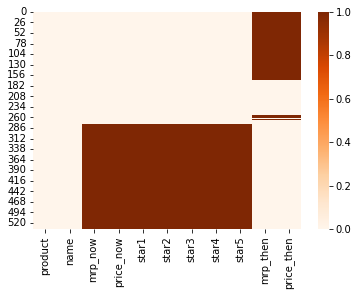

In [ ]:
# 결측값 시각화
sns.heatmap(data.isna(),cbar=True,cmap='Oranges')

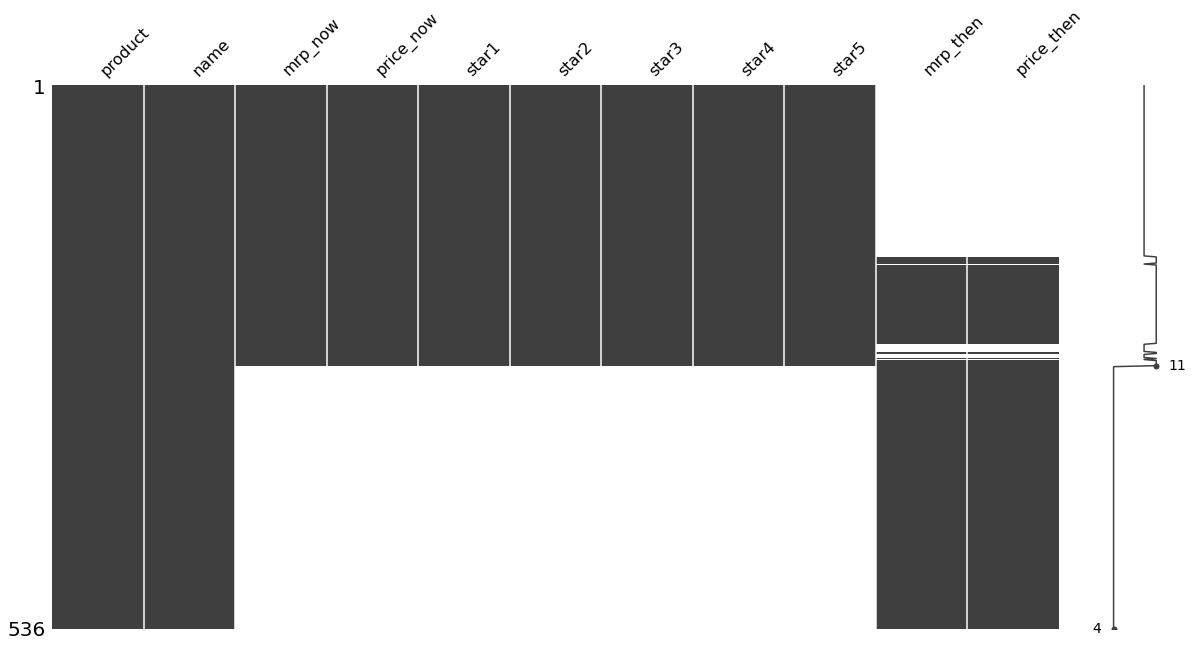

In [ ]:
missingno.matrix(data, figsize=(20,10))

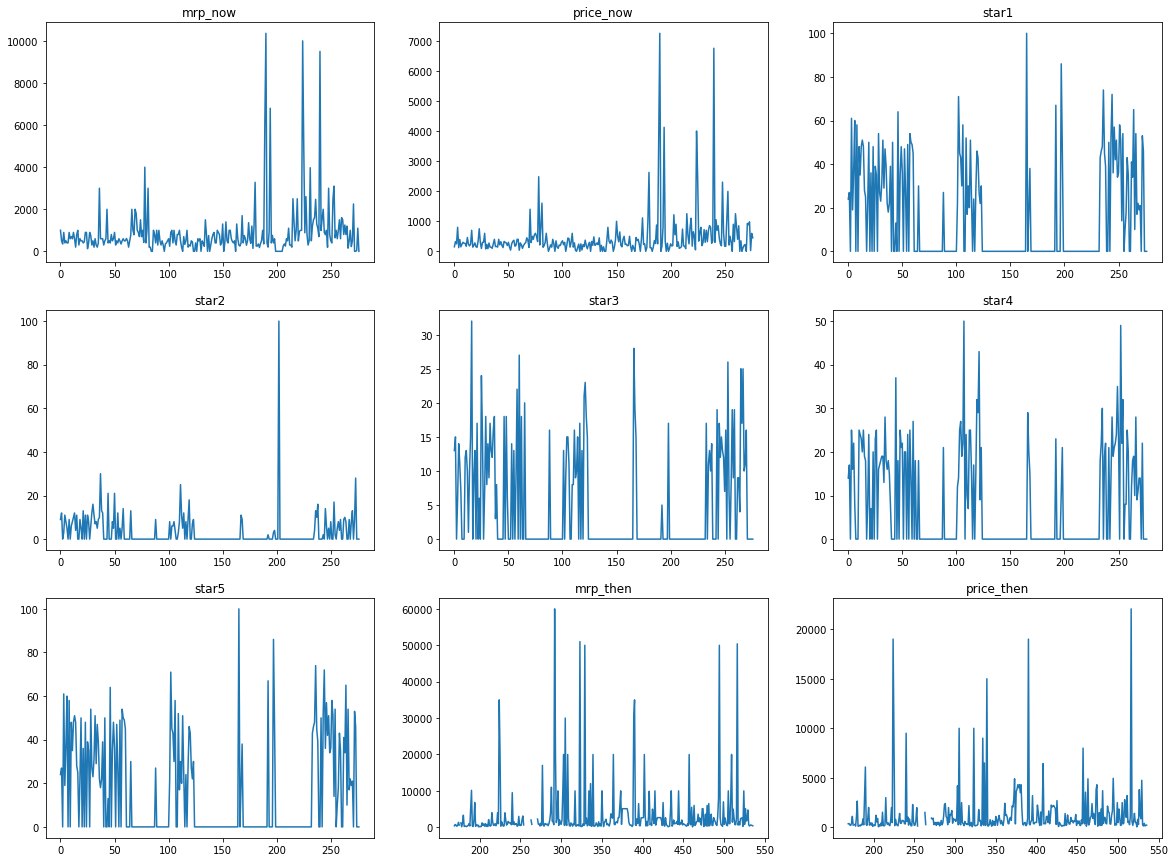

In [ ]:
# 숫자형 데이터 시각화
n_data = data.select_dtypes(include='number')
n_data_lst = n_data.columns


fig, ax = plt.subplots(3, 3, figsize=(20,15))

for i in range(len(n_data_lst)):
  visualize_data = n_data.iloc[:,i]
  ax[i//3][i%3].plot(visualize_data)
  ax[i//3][i%3].set_title(n_data_lst[i])

#### 데이터 분포 상황
- mrp_then, price_then 데이터를 제외하면 260번 이후에 데이터가 없음
- mrp_then, price_then 데이터는 150번 이전에 데이터가 없고 중간에 결측이 존재함


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  """


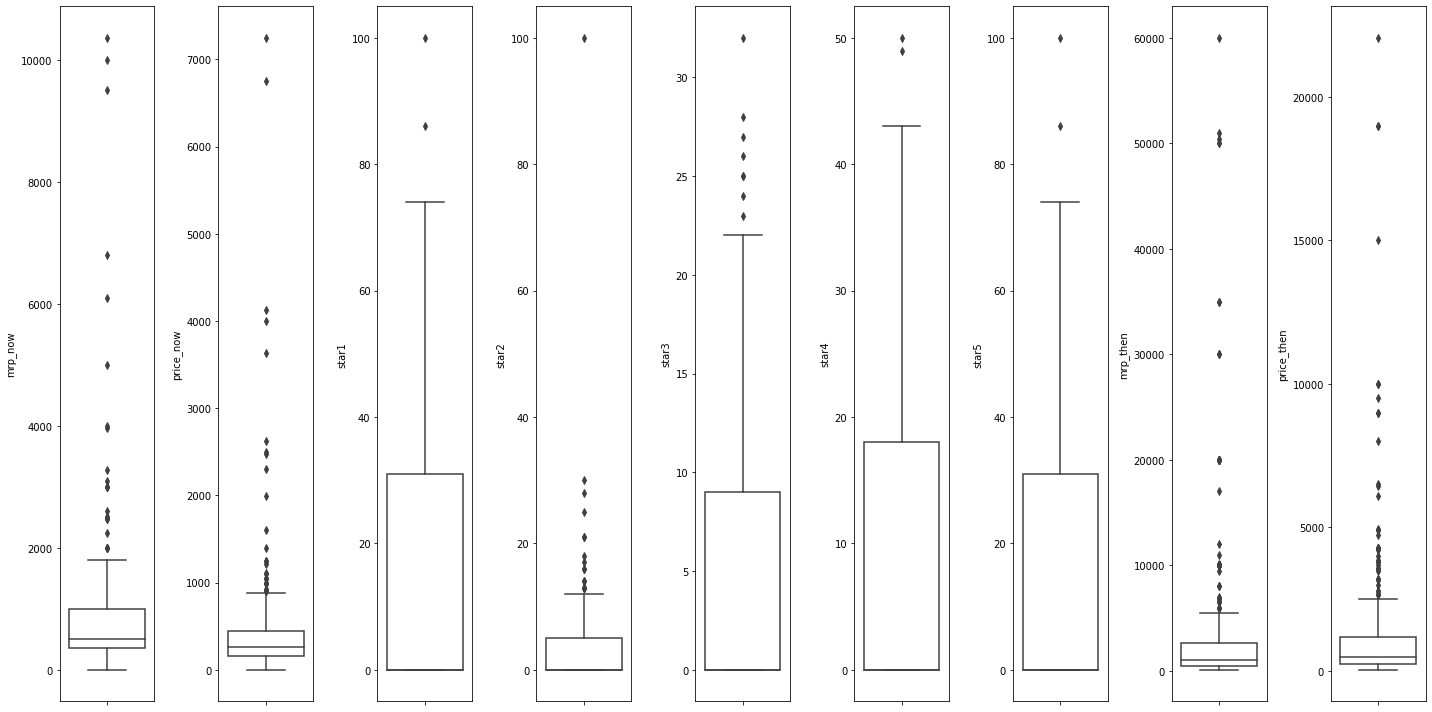

In [ ]:
fig = plt.figure(figsize=(20,10))
fig.add_subplot(1,len(n_data_lst),1) # subplot(row,col,index)
for idx,col in enumerate(n_data_lst):
  if idx >0:  
    fig.add_subplot(1,len(n_data_lst), idx+1)
  sns.boxplot(y=col, data=data, boxprops={'facecolor':'None'})
fig.tight_layout() # 자동으로 명시된 여백에 관련 서브플롯의 파라미터 조정
plt.show()

In [ ]:
# feature별 유일한 값 개수 확인
print(data.nunique().sort_values())

product         8
star2          22
star3          29
star4          30
star1          49
star5          49
mrp_now        91
mrp_then      132
price_now     148
price_then    193
name          531
dtype: int64


In [ ]:
# 인덱스와 같은 name 컬럼 삭제
data = data.drop(['name'], axis=1)
data.head()

,product,mrp_now,price_now,star1,star2,star3,star4,star5,mrp_then,price_then
0,facemasks,1000.0,151.0,24.0,9.0,13.0,14.0,24.0,NaN,NaN
1,facemasks,499.0,324.0,27.0,12.0,15.0,17.0,27.0,NaN,NaN
2,facemasks,349.0,249.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
3,facemasks,898.0,799.0,61.0,3.0,6.0,25.0,61.0,NaN,NaN
4,facemasks,399.0,121.0,19.0,11.0,14.0,16.0,19.0,NaN,NaN


### 클러스터링 & PCA

In [ ]:
data_all = data.copy()
data_all = data_all.reset_index()

In [ ]:
prd_nm = list(data_all['product'].unique())

#### 제품군별 클러스터링 
#### 최적의 k값 찾기(elbow method)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


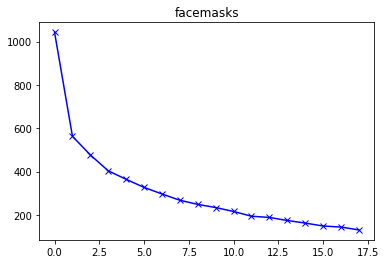

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


ppe : (<class 'ValueError'>, ValueError('n_samples=16 should be >= n_clusters=17.'), <traceback object at 0x7fdaab798b40>)
ppekits : (<class 'ValueError'>, ValueError('n_samples=3 should be >= n_clusters=4.'), <traceback object at 0x7fdaabfe74b0>)
handwash : (<class 'ValueError'>, ValueError('n_samples=1 should be >= n_clusters=2.'), <traceback object at 0x7fdaaab3d870>)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in 

Bath & Shower : (<class 'ValueError'>, ValueError('n_samples=11 should be >= n_clusters=12.'), <traceback object at 0x7fdaaab4acd0>)


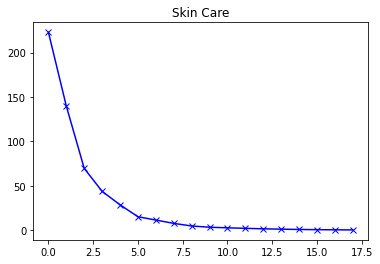

Grocery & Gourmet Foods : (<class 'ValueError'>, ValueError('n_samples=1 should be >= n_clusters=2.'), <traceback object at 0x7fdaaa274fa0>)


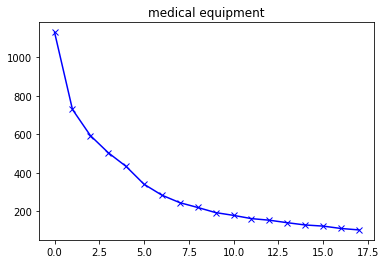

In [ ]:
scaler = StandardScaler()
valid_prd_list = []

for prd in prd_nm:

    # 각 제품별로 스케일링 진행
    df_scaled = scaler.fit_transform(data_all[['mrp_then','price_then','price_now','mrp_now','star5',"star4",'star3','star2','star1']][data_all['product']==prd])
    df_scaled=np.nan_to_num(df_scaled)  # nan값 0으로 변환
    wcss=[] # i개의 클러스터링을 하고 데이터를 학습시킨후 inertia(중심과의 거리 제곱합)값 저장 
    try:
        for i in range(1,19):
            kmeans = KMeans(n_clusters= i)
            kmeans.fit(df_scaled)
            wcss.append(kmeans.inertia_)

        plt.title(prd)
        plt.plot(wcss, 'bx-')  # wcss를 그래프로 그리고 급격하게 변화하는 값을 k로 설정 > elbow method
        plt.show()
        valid_prd_list.append(prd)  # 유효한 제품 리스트 선정(나머지 제품은 결측치 등의 문제로 클러스터링 할 수 없음)

    except:
        print(prd+' : '+str(sys.exc_info()))

In [ ]:
columnsss_amz=['mrp_then','price_then','price_now','mrp_now','star5',"star4",'star3','star2','star1']
kmeans_dict_amz={'medical equipment':7,'Skin Care': 5, 'facemasks':7} # 대략적인 k값 설정
labels_dict_amz={}
for prd in list(valid_prd_list):
    print(prd)

    # kmeans 진행
    df_scaled = scaler.fit_transform(data_all[columnsss_amz][data_all['product']==prd])
    df_scaled=np.nan_to_num(df_scaled)
    kmeans = KMeans(kmeans_dict_amz[prd])
    kmeans.fit(df_scaled) 
    labels = kmeans.labels_ # 각 데이터의 군집 라벨링
    labels_dict_amz[prd]=labels
    cluster_centers = pd.DataFrame(data = kmeans.cluster_centers_, columns = columnsss_amz) # cluster_centers_ : 군집의 중심점 위치
    df_cluster = pd.concat([data_all[columnsss_amz][data_all['product']==prd], pd.DataFrame({'cluster':labels})], axis = 1)

    print(df_cluster.head())
    print("==="*30)

facemasks
   mrp_then  price_then  price_now  mrp_now  star5  star4  star3  star2  \
0       NaN         NaN      151.0   1000.0   24.0   14.0   13.0    9.0   
1       NaN         NaN      324.0    499.0   27.0   17.0   15.0   12.0   
2       NaN         NaN      249.0    349.0    0.0    0.0    0.0    0.0   
3       NaN         NaN      799.0    898.0   61.0   25.0    6.0    3.0   
4       NaN         NaN      121.0    399.0   19.0   16.0   14.0   11.0   

   star1  cluster  
0   24.0      1.0  
1   27.0      1.0  
2    0.0      6.0  
3   61.0      2.0  
4   19.0      1.0  
Skin Care
   mrp_then  price_then  price_now  mrp_now  star5  star4  star3  star2  \
0       NaN         NaN        NaN      NaN    NaN    NaN    NaN    NaN   
1       NaN         NaN        NaN      NaN    NaN    NaN    NaN    NaN   
2       NaN         NaN        NaN      NaN    NaN    NaN    NaN    NaN   
3       NaN         NaN        NaN      NaN    NaN    NaN    NaN    NaN   
4       NaN         NaN        NaN

/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


   mrp_then  price_then  price_now  mrp_now  star5  star4  star3  star2  \
0       NaN         NaN        NaN      NaN    NaN    NaN    NaN    NaN   
1       NaN         NaN        NaN      NaN    NaN    NaN    NaN    NaN   
2       NaN         NaN        NaN      NaN    NaN    NaN    NaN    NaN   
3       NaN         NaN        NaN      NaN    NaN    NaN    NaN    NaN   
4       NaN         NaN        NaN      NaN    NaN    NaN    NaN    NaN   

   star1  cluster  
0    NaN      4.0  
1    NaN      4.0  
2    NaN      4.0  
3    NaN      4.0  
4    NaN      4.0  


facemasks


/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.7/dist-packages/sklearn/utils/extmath.py:1020: RuntimeWarning: invalid value encountered in true_divide
  new_unnormalized_variance -= correction ** 2 / new_sample_count


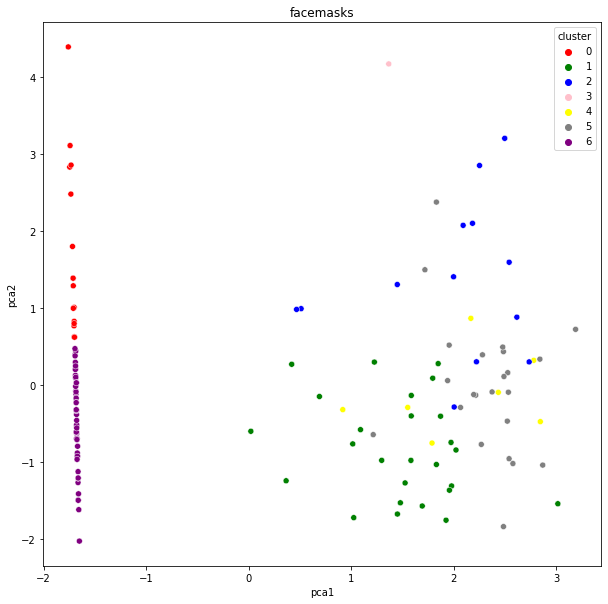

Skin Care


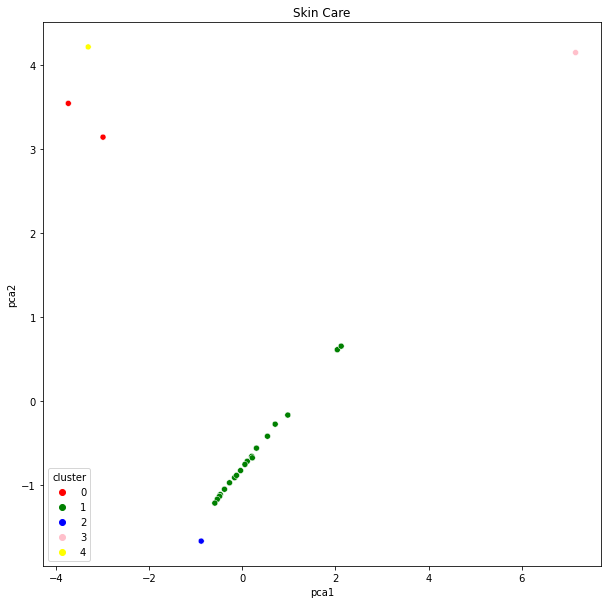

medical equipment


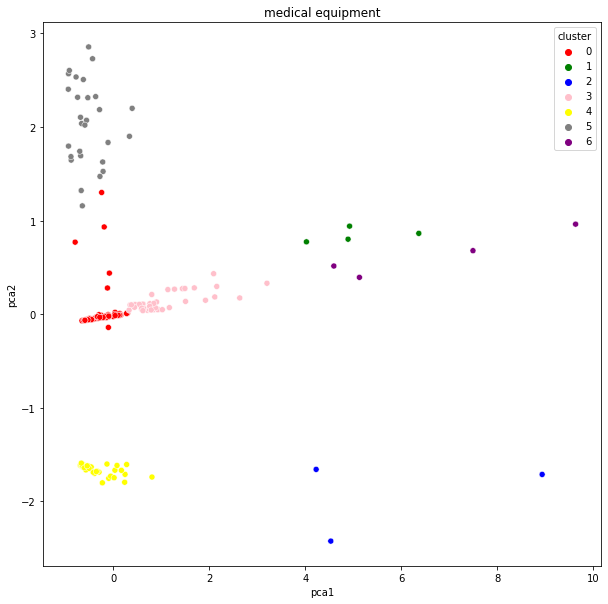

In [ ]:
palette =['red','green','blue','pink','yellow','gray','purple','black', 'magenta','cyan' ]
for prd in valid_prd_list:
    print(prd)
    # 스케일링
    df_scaled = scaler.fit_transform(data_all[['mrp_then','price_then','price_now','mrp_now','star5',"star4",'star3','star2','star1']][data_all['product']==prd])
    df_scaled=np.nan_to_num(df_scaled)

    # pca
    pca = PCA(n_components=2)  # 차원 설정
    principal_comp = pca.fit_transform(df_scaled)
    pca_df = pd.DataFrame(data = principal_comp, columns =['pca1','pca2'])
    pca_df = pd.concat([pca_df,pd.DataFrame({'cluster':labels_dict_amz[prd]})], axis = 1) # pca 데이터프레임에 라벨값 추가

    plt.figure(figsize=(10,10))
    ax = sns.scatterplot(x="pca1", y="pca2", hue = "cluster", data = pca_df, palette=palette[:kmeans_dict_amz[prd]])
    plt.title(prd)
    plt.show()

In [ ]:
data.to_csv("/content/drive/MyDrive/ML_Practice/04_covid_amz_ml/data.csv",index=False)